<h1 align='center'>Time-Series Analysis on TATA Steel</h1>
<h3 align='center'>Analyze the Data and Predict the Price of the Stock till January</h3>

### Import Initial Packages

In [1]:
# Import Dependencies -To see the graphs in the notebook.
%matplotlib inline   

# Python Imports
import math,time,random,datetime

# Data Manipulation
import numpy as np
import pandas as pd

# Visualization -This is where the graphs come in.
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns

# Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

#### OBJECTIVES:
1. Data Cleaning 
    - Convert to Date-Time Format
    - Select the Necessary Column
    - Remove unnecessary values
2. Visualize the Data
3. Check for Stationarity (ACF Plot & ADF Test)
    - If Stationary >> AR/MA/ARMA Model
    - If Non-Stationary >> ARIMA/SARIMAX Model
4. Remove Non-Stationarity (If Needed)
    - Differencing
    - Seasonal Differencing
    - Both Differencing and Seasonal Differencing
5. Choose the lags to be Included (ACF & PACF Plot)
    - p for AR Model >> PACF 
    - d for any Differencing
    - q for MA Model >> ACF
6. Split the Data into Train and Test
7. Build the Model
    - SARIMAX(p,d,q)

#### END-GOAL:
1. Predict the Tata-Steel Stock Closing Price uptill January 2022 end.
2. Compare multiple models for the Analysis.

### Loading the Required Data

In [2]:
### Load and View the Data
df = pd.read_csv('TATASTEEL.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-01-01,645.0,649.700012,640.000000,643.099976,629.023438,8411396
1,2021-01-04,649.0,699.900024,646.450012,693.000000,677.831238,38184955
2,2021-01-05,687.0,693.849976,675.099976,680.549988,665.653748,21545254
3,2021-01-06,684.0,696.650024,675.000000,683.799988,668.832581,19610522
4,2021-01-07,693.0,731.500000,691.700012,722.799988,706.978943,38232194


### Data Preprocessing

In [3]:
### Understanding the Data Type
df.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

- We can see that the **Date** Column is of type *'object'*. We will convert them to DateTime format.
- Adding the ***parse_dates=['Date']*** argument when reading the data will make the **Date** Column to be parsed as a Date field.

In [4]:
### Converting the 'Date' Column to datetime format
df["Date"] = pd.to_datetime(df["Date"])
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-01-01,645.0,649.700012,640.000000,643.099976,629.023438,8411396
1,2021-01-04,649.0,699.900024,646.450012,693.000000,677.831238,38184955
2,2021-01-05,687.0,693.849976,675.099976,680.549988,665.653748,21545254
3,2021-01-06,684.0,696.650024,675.000000,683.799988,668.832581,19610522
4,2021-01-07,693.0,731.500000,691.700012,722.799988,706.978943,38232194


- It can also be noted that the Date is starting from December and we want them to be from the ***First of January***.

In [5]:
### Extracting the Data from then First of January using Boolean Masking
mask = (df['Date'] >= '2021-01-01')
df = df.loc[mask]

df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-01-01,645.0,649.700012,640.000000,643.099976,629.023438,8411396
1,2021-01-04,649.0,699.900024,646.450012,693.000000,677.831238,38184955
2,2021-01-05,687.0,693.849976,675.099976,680.549988,665.653748,21545254
3,2021-01-06,684.0,696.650024,675.000000,683.799988,668.832581,19610522
4,2021-01-07,693.0,731.500000,691.700012,722.799988,706.978943,38232194


In [6]:
## Resetting the Index and Selecting only the Closing Price.
df_Close = df.copy()
df_Close.set_index('Date', inplace= True)

df_Close = df_Close['Close'].to_frame() 
df_Close.head()

,Close
Date,
2021-01-01,643.099976
2021-01-04,693.000000
2021-01-05,680.549988
2021-01-06,683.799988
2021-01-07,722.799988


In [7]:
## Checking for Null Values
df_Close.isnull().any()

Close    False
dtype: bool

### Time-Series Patterns


Any time series may be split into the following components: 
- Trend
- Seasonality
- Error 

A trend is observed when there is an increasing or decreasing slope observed in the time series. Whereas seasonality is observed when there is a distinct repeated pattern observed between regular intervals due to seasonal factors. It could be because of the month of the year, the day of the month, weekdays or even time of the day. 

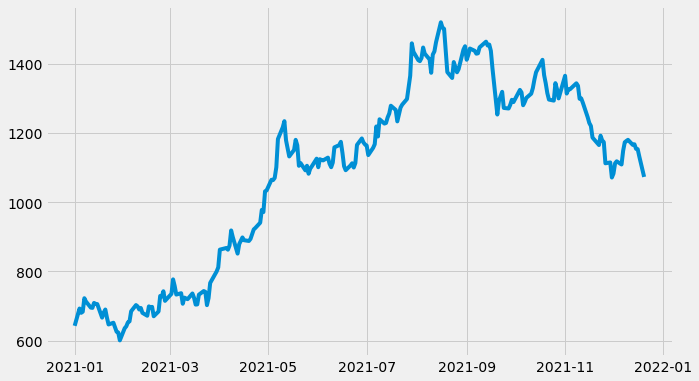

In [8]:
# Visualizing the Closing Prices
plt.figure(figsize=(10,6))
plt.plot(df_Close)

- We can see that till <u>September there was an Increasing Trend and then it is seen that there is a Decreasing Trend</u>.
- There seems to be some kind of Seasonality present. We will look into this furthur on the road.

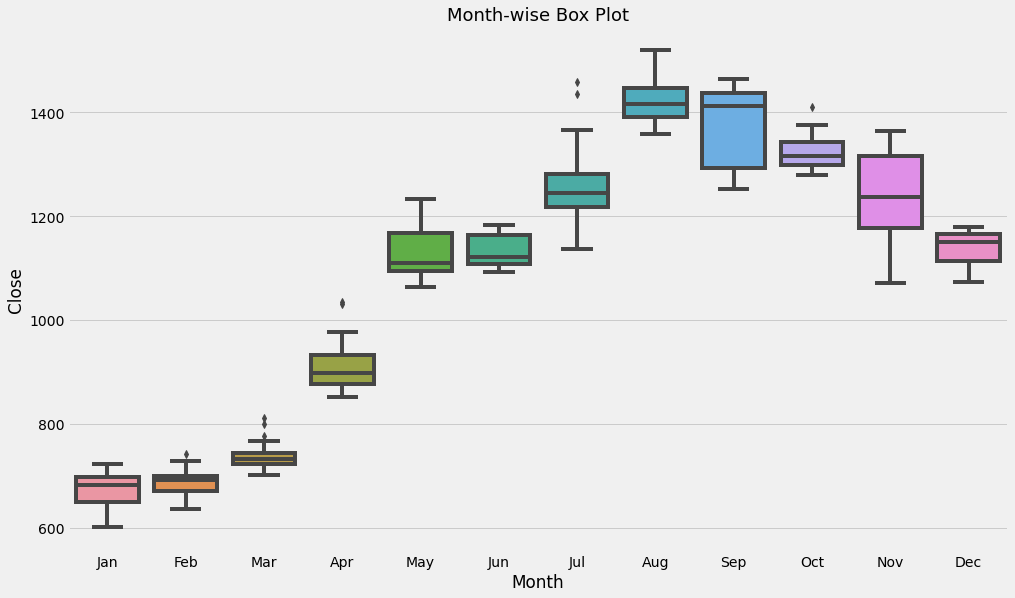

In [9]:
                                                        ######## EXTRAS ########
## Month-Wise Box Plot
plt.figure(figsize=(15,9))
df['Month'] = [d.strftime('%b') for d in df.Date]
sns.boxplot(x='Month', y='Close', data=df)

# Set Title
plt.title('Month-wise Box Plot', fontsize=18)
plt.show()

> The boxplots make the Month-Wise Distributions evident. Also, in a Month-Wise boxplot, the Month of August clearly has higher Closing Price, this is because of Tata-Steel was one of the 5 newsmakers for that Month.

**REFERENCE:** https://www.zeebiz.com/topics/tata-steel

### Understanding the Stationarity Condition

#### Separate Trend and Seasonality.

- This we are doing so that we understand whether we have to choose the Additive or Multiplicative Model.
- This is also helpful in understanding whether there are any Deterministic Components *(Trend, Seasonality)* present.

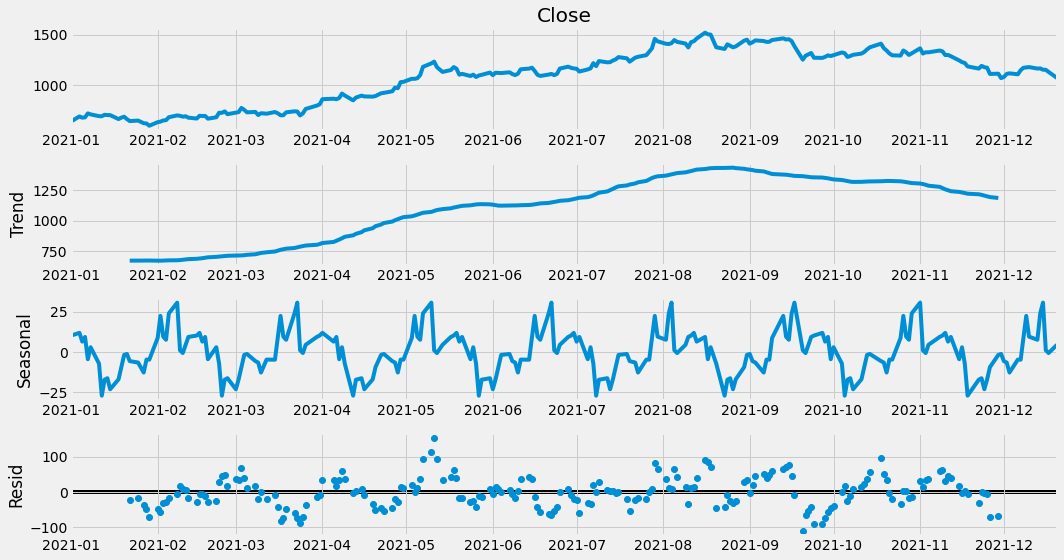

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df_Close['Close'], freq = 30)

plt.rcParams.update({'figure.figsize': (15,8)})
decomposition.plot()
plt.show()

  > If you look at the residuals of the Decomposition closely, it looks quite random which is good. S
  > We can also see that there is Seasonality present in the Data. 

#### ACF Plot

Auto-Correlation Function plot (ACF Plot) is one of the mehods that is used to understand if our Dataset is Stationary or Not. We can also use this to find the Order of Dependency (Determie the Number of Lags to be included in the AR Model)

- If the values in the ACF plot lie within the threshild value (0.2), then we say that the variables are **uncorrelated**. Then this plot is considered as ***ACF Plot of Stationary Data.***

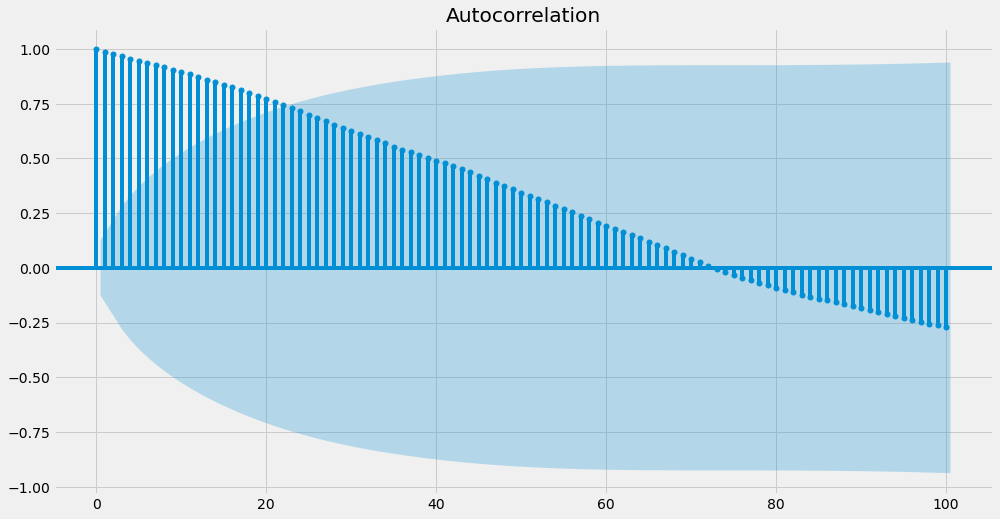

In [11]:
## Plotting the ACF Plot
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(df_Close['Close'], lags= 100)
plt.show()

<strong>INFERENCE</strong>

- From the above plot we can see that the Model is not Stationary (As all major values are above the threshold values). 
- We can see that till lag 55 the values are Significant.

#### ADF Test
Augmented Dickey Fuller test (ADF Test) is a common statistical test used to test whether a given Time series is stationary or not. It is one of the most commonly used statistical test when it comes to analyzing the stationary of a series.

- A key point to remember here is: Since the null hypothesis assumes the presence of unit root, that is α=1, the p-value obtained should be less than the significance level (say 0.05) in order to reject the null hypothesis.

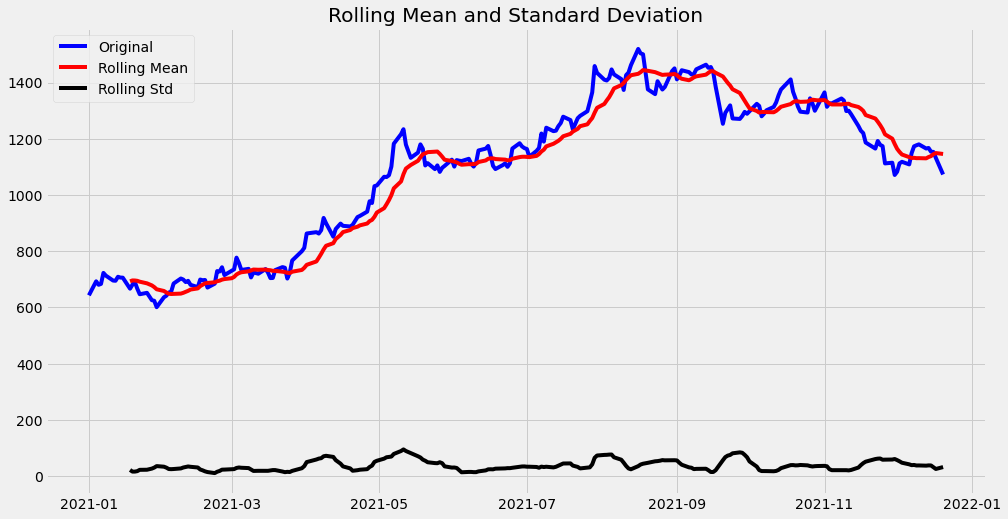

Results of Dickey Fuller Test
Test Statistics                 -1.409478
p-value                          0.577724
No. of lags used                 4.000000
Number of observations used    234.000000
critical value (1%)             -3.458608
critical value (5%)             -2.873972
critical value (10%)            -2.573396
dtype: float64


In [12]:
from statsmodels.tsa.stattools import adfuller

### H0: The series is non-stationary (phi=1)
### H1: The series is stationary (phi#1)

# Test for Staionarity
def test_stationarity(timeseries):
    # Determing Rolling Statistics -- The series becomes Stationary if both the Mean and Standard Deviation are flat lines (constant Mean and constant Variance).
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    # Plotting Rolling Statistics
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)


    print("Results of Dickey Fuller Test")
    adft = adfuller(timeseries,autolag= 'AIC')
    
    # Output for ADF test will give us without defining what the values are. Hence we manually write what values does it explain using a for loop.
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)


test_stationarity(df_Close)

- The Increasing Mean and Standard Deviation may be seen in the graph above, indicating that our series isn’t Stationary.

> **p-value:** The p-value is the probability of obtaining a result at least as extreme as the one that was actually observed, assuming the null hypothesis is true.

The p-value is obtained is greater than significance level of 0.05 and the ADF statistic is higher than any of the critical values. Clearly, there is no reason to reject the null hypothesis. So, the time series is in fact non-stationary.

- Since the model is Non-Stationary, let us build it using either the ARIMA and SARIMAX models (Non-Stationary Class of Time-Series Model).

### Removing the Presence of Non-Stationarity

#### Method of Differencing

Differencing is a method of transforming a time series dataset.
It can be used to Remove the Series Dependence on time, so-called Temporal Dependence. This includes structures like Trends and Seasonality.
- This should help to eliminate the overall trend from the data.

In [13]:
## De-Trending the Series
df_Close['Close First Difference'] = df_Close['Close'] - df_Close['Close'].shift(1)
df_Close.head(10)

,Close,Close First Difference
Date,,
2021-01-01,643.099976,NaN
2021-01-04,693.000000,49.900024
2021-01-05,680.549988,-12.450012
2021-01-06,683.799988,3.250000
2021-01-07,722.799988,39.000000
2021-01-08,713.150024,-9.649964
2021-01-11,695.650024,-17.500000
2021-01-12,694.900024,-0.750000
2021-01-13,709.150024,14.250000


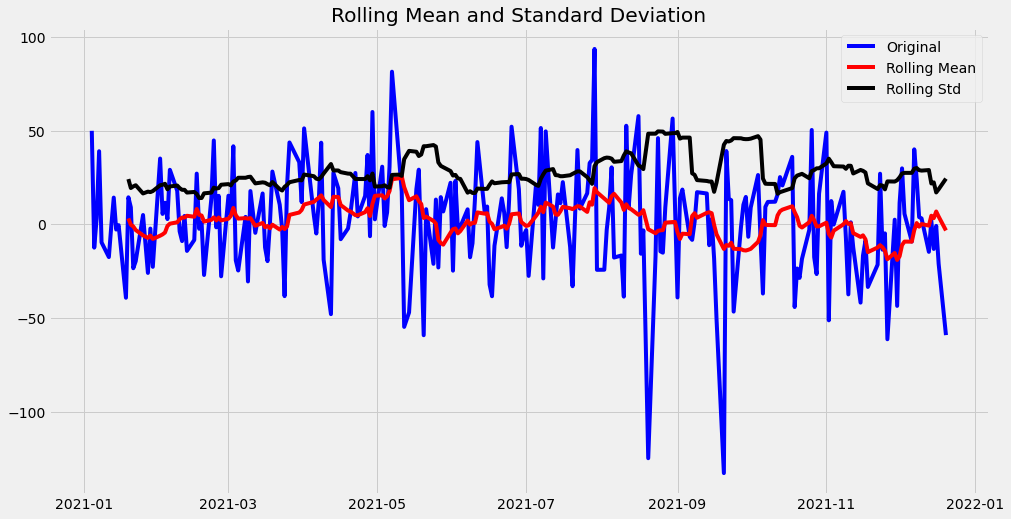

Results of Dickey Fuller Test
Test Statistics               -7.125475e+00
p-value                        3.629764e-10
No. of lags used               3.000000e+00
Number of observations used    2.340000e+02
critical value (1%)           -3.458608e+00
critical value (5%)           -2.873972e+00
critical value (10%)          -2.573396e+00
dtype: float64


In [14]:
test_stationarity(df_Close['Close First Difference'].dropna())      ### Remove the Null Value Formed by the First Difference.

#### Method of Seasonal Differencing

In [15]:
df_Close['Close Seasonal Difference'] = df_Close['Close'] - df_Close['Close'].shift(12)
df_Close['Close Seasonal Difference'] = df_Close['Close Seasonal Difference'] - df_Close['Close Seasonal Difference'].shift(24)
df_Close.head(10)

,Close,Close First Difference,Close Seasonal Difference
Date,,,
2021-01-01,643.099976,NaN,NaN
2021-01-04,693.000000,49.900024,NaN
2021-01-05,680.549988,-12.450012,NaN
2021-01-06,683.799988,3.250000,NaN
2021-01-07,722.799988,39.000000,NaN
2021-01-08,713.150024,-9.649964,NaN
2021-01-11,695.650024,-17.500000,NaN
2021-01-12,694.900024,-0.750000,NaN
2021-01-13,709.150024,14.250000,NaN


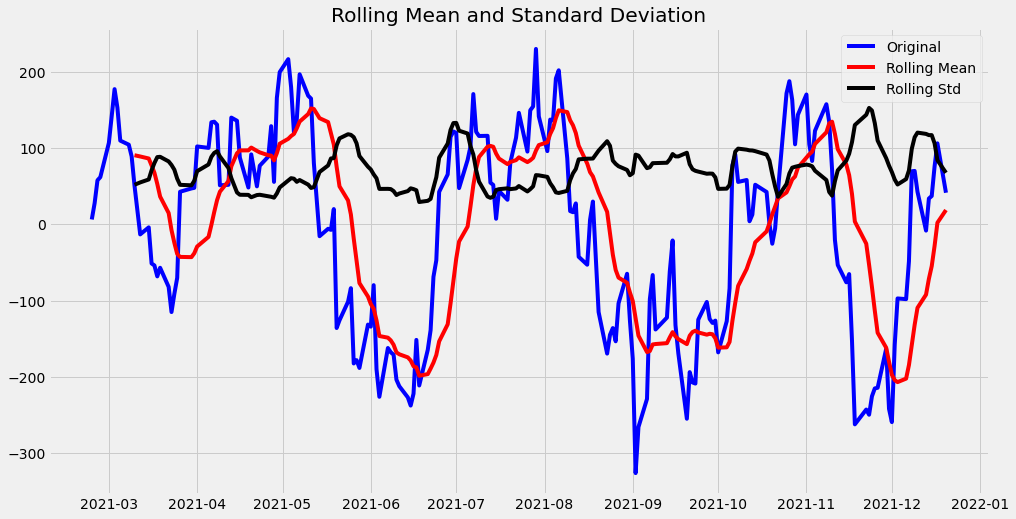

Results of Dickey Fuller Test
Test Statistics                 -3.032788
p-value                          0.031944
No. of lags used                12.000000
Number of observations used    190.000000
critical value (1%)             -3.465244
critical value (5%)             -2.876875
critical value (10%)            -2.574945
dtype: float64


In [16]:
test_stationarity(df_Close['Close Seasonal Difference'].dropna())      ### Remove the Null Value Formed by the Seasonal Difference.

#### Method of Seasonal First Differencing

In [17]:
df_Close['Seasonal First Difference'] = df_Close['Close First Difference'] - df_Close['Close First Difference'].shift(12)
df_Close.head(10)

,Close,Close First Difference,Close Seasonal Difference,Seasonal First Difference
Date,,,,
2021-01-01,643.099976,NaN,NaN,NaN
2021-01-04,693.000000,49.900024,NaN,NaN
2021-01-05,680.549988,-12.450012,NaN,NaN
2021-01-06,683.799988,3.250000,NaN,NaN
2021-01-07,722.799988,39.000000,NaN,NaN
2021-01-08,713.150024,-9.649964,NaN,NaN
2021-01-11,695.650024,-17.500000,NaN,NaN
2021-01-12,694.900024,-0.750000,NaN,NaN
2021-01-13,709.150024,14.250000,NaN,NaN


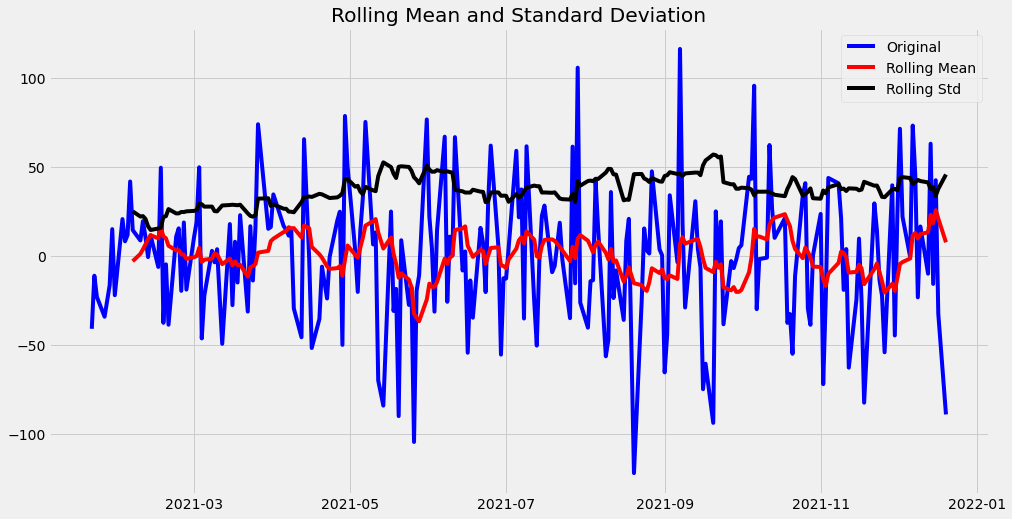

Results of Dickey Fuller Test
Test Statistics               -7.660314e+00
p-value                        1.695528e-11
No. of lags used               1.100000e+01
Number of observations used    2.140000e+02
critical value (1%)           -3.461282e+00
critical value (5%)           -2.875143e+00
critical value (10%)          -2.574020e+00
dtype: float64


In [18]:
test_stationarity(df_Close['Seasonal First Difference'].dropna())      ### Remove the Null Value Formed by the Seasonal First Difference.

#### Log Transformation

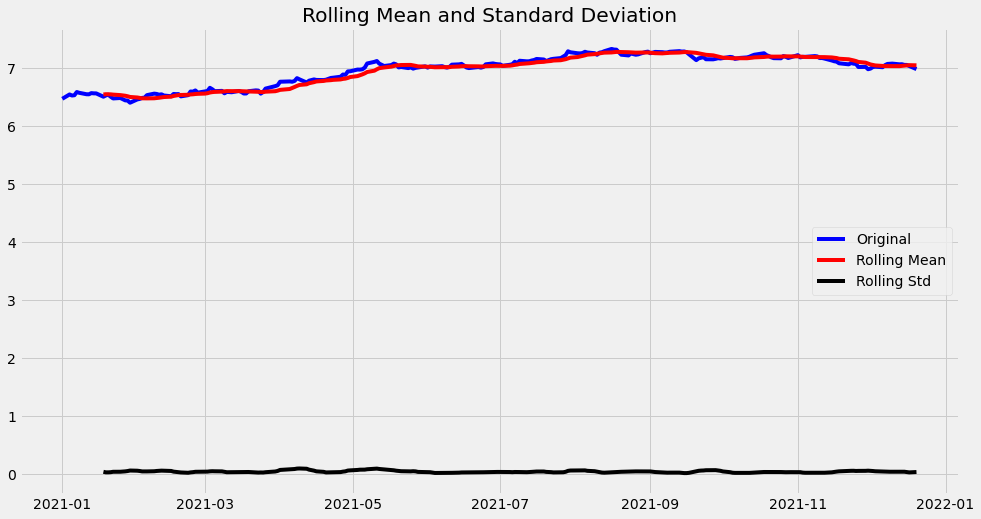

Results of Dickey Fuller Test
Test Statistics                 -1.400123
p-value                          0.582217
No. of lags used                 4.000000
Number of observations used    234.000000
critical value (1%)             -3.458608
critical value (5%)             -2.873972
critical value (10%)            -2.573396
dtype: float64


In [19]:
#Eliminate trend≈
df_log = np.log(df_Close)

test_stationarity(df_log['Close'])

- As you can see by the p-value, taking the Close First Difference and the Seasonal First Difference has made our Data Stationary. 
- Even though the p-value of Close Seasonal Difference is significant we conclude that we are 95% confident that our Time Series Data is Stationary (Test Statistic is not greater than 1% Critical Value). 
- As for the Log-Transformation we can see that the based on the p-value our data is still non-stationary. 

### Seasonal Auto-Regressive Integrated Moving Average (SARIMAX)

#### Auto Regressive Model

Identification of an AR model is often best done with the PACF.
- For an AR model, the theoretical PACF “shuts off” past the order of the model. The phrase “shuts off” means that in theory the partial autocorrelations are equal to 0 beyond that point. Put another way, the number of non-zero partial autocorrelations gives the order of the AR model. By the “order of the model” we mean the most extreme lag of x that is used as a predictor.

#### Moving Average Model
Identification of an MA model is often best done with the ACF rather than the PACF.
- For an MA model, the theoretical PACF does not shut off, but instead tapers toward 0 in some manner. A clearer pattern for an MA model is in the ACF. The ACF will have non-zero autocorrelations only at lags involved in the model.

|  |  |
| --- | --- |
| p | AR Model Lags|
| d | Differencing|
| q | MA Model Lags|

In [20]:
df_Close.head()

,Close,Close First Difference,Close Seasonal Difference,Seasonal First Difference
Date,,,,
2021-01-01,643.099976,NaN,NaN,NaN
2021-01-04,693.000000,49.900024,NaN,NaN
2021-01-05,680.549988,-12.450012,NaN,NaN
2021-01-06,683.799988,3.250000,NaN,NaN
2021-01-07,722.799988,39.000000,NaN,NaN


#### Order for a SARIMAX Model

##### 1. Using Close First Difference

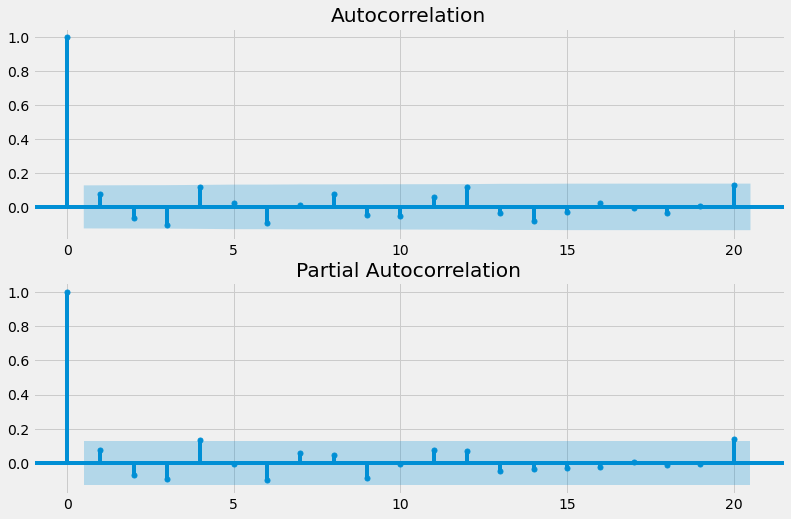

In [22]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df_Close['Close First Difference'].dropna(),lags= 20,ax= ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df_Close['Close First Difference'].dropna(),lags= 20,ax= ax2)

**INFERENCE**
- When considering the AR Model the PACF values don't go beyond 0. But the value 4 is beyond the threshold value.
- For the MA Model we can see that the ACF values also don't go beyond 0. But the value 4 is beyond the threshold value.
- As for the Integrated (Differencing) value we will be going with 1.

In [23]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model_SARIMAX = SARIMAX(df_Close['Close'], trend='n', order=(4,1,4), seasonal_order=(4,1,4,12))

model_SARIMAX_fit = model_SARIMAX.fit()

print(model_SARIMAX_fit.summary())  # Summary of Fit Model

/Users/eben.emmanuel/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/eben.emmanuel/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.66427D+00    |proj g|=  2.13082D-01

At iterate    5    f=  4.59562D+00    |proj g|=  1.00757D-02

At iterate   10    f=  4.58808D+00    |proj g|=  2.74026D-02

At iterate   15    f=  4.57800D+00    |proj g|=  5.58455D-02

At iterate   20    f=  4.56859D+00    |proj g|=  4.11257D-02

At iterate   25    f=  4.56519D+00    |proj g|=  1.02814D-01

At iterate   30    f=  4.56236D+00    |proj g|=  5.49783D-02

At iterate   35    f=  4.56049D+00    |proj g|=  8.75667D-02

At iterate   40    f=  4.55461D+00    |proj g|=  9.11925D-02

At iterate   45    f=  4.55280D+00    |proj g|=  9.53381D-02

At iterate   50    f=  4.55186D+00    |proj g|=  8.15106D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/eben.emmanuel/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                  239
Model:             SARIMAX(4, 1, 4)x(4, 1, 4, 12)   Log Likelihood               -1087.894
Date:                            Mon, 10 Jan 2022   AIC                           2209.788
Time:                                    16:28:38   BIC                           2267.937
Sample:                                         0   HQIC                          2233.255
                                            - 239                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1161      2.513      0.046      0.963      -4.809       5.041
ar.L2         -0.2417      2.206   

**INFERENCE**
- We can see that the SARIMAX (4,1,3) Model predicts well.
- One major drawback was that the time taken was a bit too much (37 minutes).

**REFERENCE**

When choosing the Seasonal Order the reference was made from here: https://towardsdatascience.com/understanding-the-seasonal-order-of-the-sarima-model-ebef613e40fa

### Checking SARIMAX (4,1,4) Model

In [24]:
df_Close.tail()

,Close,Close First Difference,Close Seasonal Difference,Seasonal First Difference
Date,,,,
2021-12-14,1167.199951,1.899902,33.649902,63.249877
2021-12-15,1154.050049,-13.149902,37.000000,-15.599853
2021-12-16,1153.199951,-0.850098,75.700073,42.699951
2021-12-17,1132.099976,-21.099975,105.949951,-32.450073
2021-12-20,1072.949951,-59.150025,41.250000,-89.000000


<AxesSubplot:xlabel='Date'>

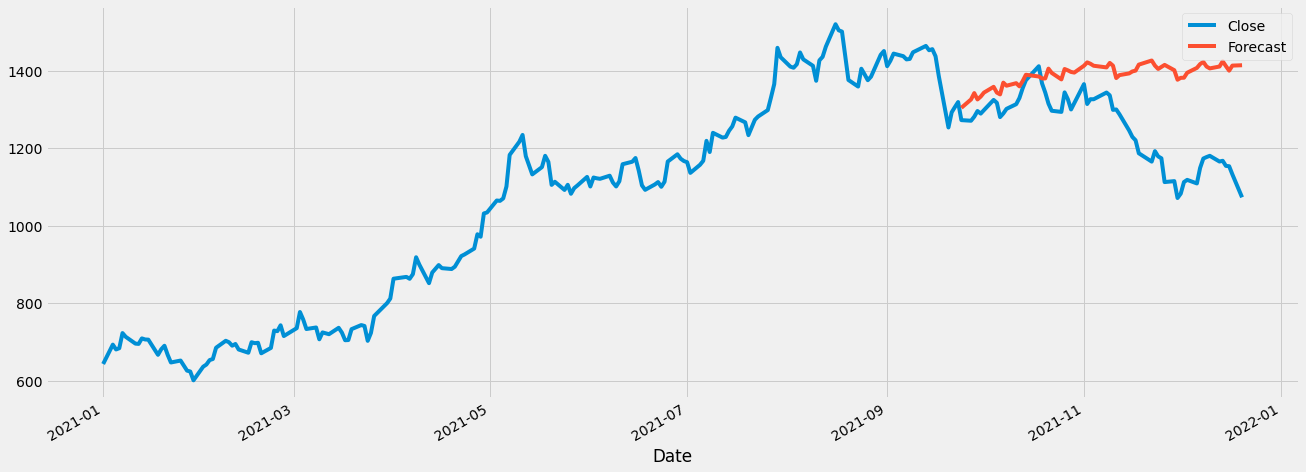

In [25]:
## Checking if our Model is Forcasting well for the existing Data.
df_Close['Forecast'] = model_SARIMAX_fit.predict(start= 180, end= 238, dynamic= True)
df_Close[['Close','Forecast']].plot(figsize= (20,8))

- Using the **predict()** function we are trying to predict the Closing Price of the existing Days. This is acting just as a confirmation to see how the model will be predicting/forecasting for any data. 

- We can conclude that the prediction/forecast is not that accurate. This maybe because of the presence of Seasonality. Even though the Predicted Closing Prices are Declining we can't accuratly say that the model is Forecasting well.

### Forecasting the Stock Closing Price SARIMAX (4,1,4)

In [26]:
len(df_Close) ## Understanding the length of the Data.

239

In [27]:
Days_Required = 30

df_next = pd.DataFrame(model_SARIMAX_fit.forecast(steps= Days_Required, alpha= 0.05))       ## 95% Confidence Interval
df_next['Date'] = pd.date_range(start= datetime.date(2021, 12, 21), periods= Days_Required, freq= 'B')      ## Obtaining only the Business Days.

df_next.rename(columns = {'predicted_mean':'Close'}, inplace = True)

df_next.tail()

/Users/eben.emmanuel/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


,Close,Date
264,1141.763609,2022-01-25
265,1159.446525,2022-01-26
266,1167.812503,2022-01-27
267,1160.075875,2022-01-28
268,1163.996150,2022-01-31


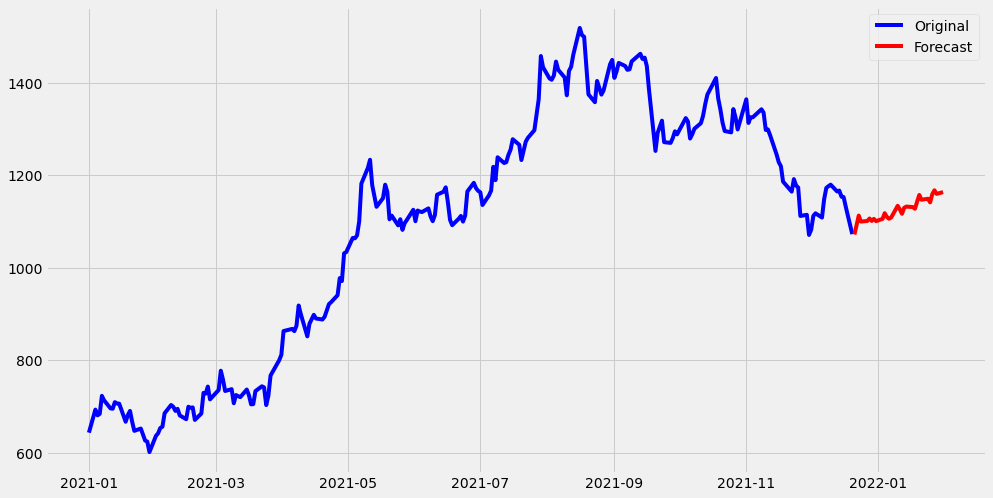

In [28]:
df_forecast = df_next.copy()
df_forecast.set_index('Date', inplace= True)

plt.plot(df_Close['Close'], color= 'blue', label= 'Original')
plt.plot(df_forecast['Close'], color= 'red', label= 'Forecast')
plt.legend(loc='best')
plt.show()

# plt.plot(df_forecast['Close'], color= 'green', label= 'Forecast')
# plt.legend(loc='best')
# plt.show()

#### Combining the Dataframes

In [29]:
df_final1 = pd.concat([df_Close, df_forecast], axis=0)
df_final1 = df_final1.loc[:,['Close']]
df_final1.tail(31)

,Close
Date,
2021-12-20,1072.949951
2021-12-21,1072.140361
2021-12-22,1092.494941
2021-12-23,1113.169545
2021-12-24,1100.092928
2021-12-27,1101.539247
2021-12-28,1106.775674
2021-12-29,1101.534113
2021-12-30,1105.970531


In [30]:
len(df_final1)

269

---

##### 2. Using Seasonal First Difference

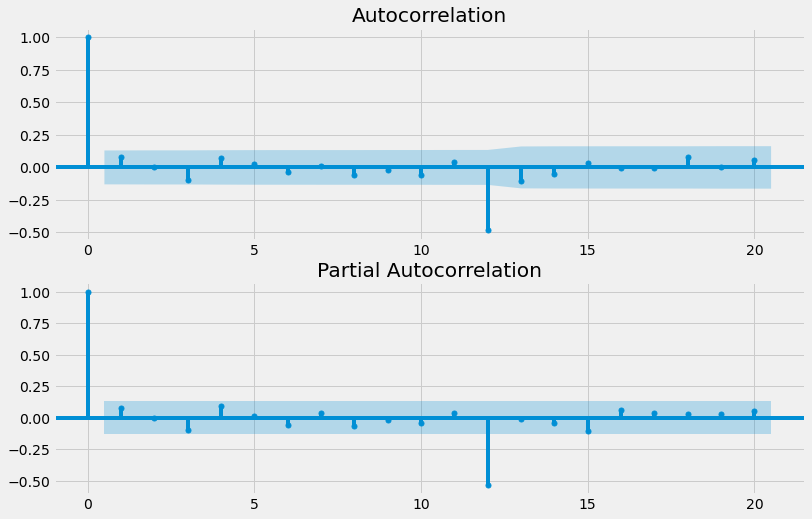

In [31]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df_Close['Seasonal First Difference'].dropna(),lags= 20,ax= ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df_Close['Seasonal First Difference'].dropna(),lags= 20,ax= ax2)

**INFERENCE**
- When considering the AR Model the PACF values don't go beyond 0. But the value 3/4 is beyond the threshold value.
- For the MA Model we can see that the ACF values also don't go beyond 0. But the value 3 is beyond the threshold value.
- As for the Integrated (Differencing) value we will be going with 1 and 2.

##### ORDER (3,1,3)

In [32]:
model_SARIMAX2 = SARIMAX(df_Close.Close, trend='n', order=(3,1,3), seasonal_order=(3,1,3,12))

model_SARIMAX2_fit = model_SARIMAX2.fit()

print(model_SARIMAX2_fit.summary())  # Summary of Fit Model

/Users/eben.emmanuel/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/eben.emmanuel/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.64375D+00    |proj g|=  1.81291D-01

At iterate    5    f=  4.60717D+00    |proj g|=  2.75874D-02

At iterate   10    f=  4.59886D+00    |proj g|=  4.56024D-02

At iterate   15    f=  4.58947D+00    |proj g|=  4.97268D-02

At iterate   20    f=  4.56015D+00    |proj g|=  1.06892D-01

At iterate   25    f=  4.54390D+00    |proj g|=  7.04101D-02

At iterate   30    f=  4.54225D+00    |proj g|=  2.15743D-02

At iterate   35    f=  4.54206D+00    |proj g|=  2.31992D-02

At iterate   40    f=  4.54167D+00    |proj g|=  2.57172D-02

At iterate   45    f=  4.54162D+00    |proj g|=  9.93763D-03


/Users/eben.emmanuel/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  4.54158D+00    |proj g|=  3.61635D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     65      1     0     0   3.616D-02   4.542D+00
  F =   4.5415810913973393     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                  239
Model:             SARIMAX(3, 1, 3)x(3, 1, 3, 12)   Log Likelihood               -1085.438
Date:                            Mon, 10 Jan 2022   AIC                           2196.8

### Checking SARIMAX (3,1,3) Model

<AxesSubplot:xlabel='Date'>

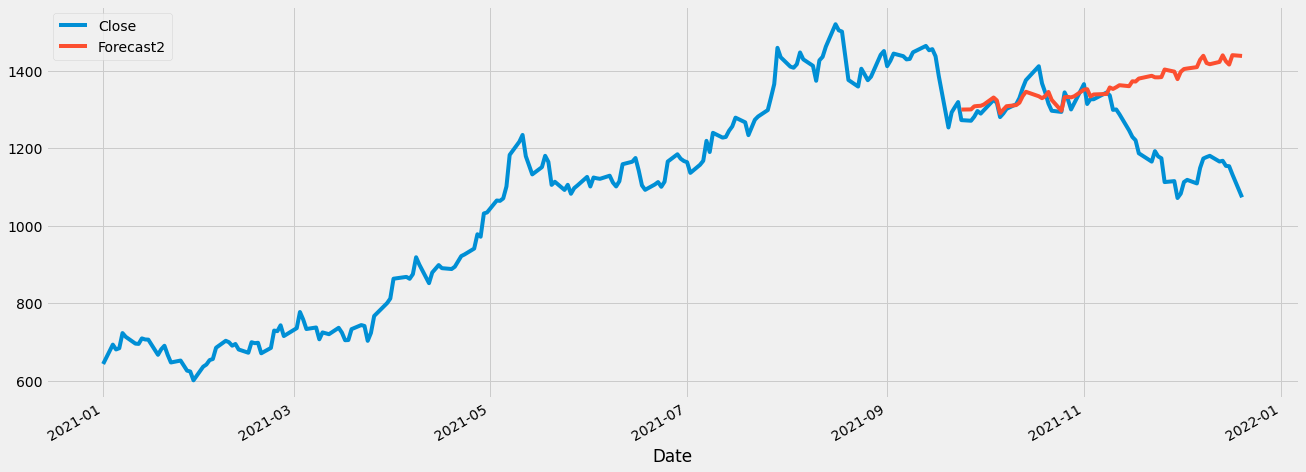

In [33]:
## Checking if our Model is Forcasting well for the existing Data.
df_Close['Forecast2'] = model_SARIMAX2_fit.predict(start= 180, end= 238, dynamic= True)
df_Close[['Close','Forecast2']].plot(figsize= (20,8))

### Forecasting the Stock Closing Price SARIMAX (3,1,3)

In [34]:
Days_Required = 30

df_next1 = pd.DataFrame(model_SARIMAX2_fit.forecast(steps= Days_Required, alpha= 0.05))       ## 95% Confidence Interval
df_next1['Date'] = pd.date_range(start= datetime.date(2021, 12, 21), periods= Days_Required, freq= 'B')      ## Obtaining only the Business Days.

df_next1.rename(columns = {'predicted_mean':'Close'}, inplace = True)

df_next1.tail()

/Users/eben.emmanuel/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


,Close,Date
264,1069.122816,2022-01-25
265,1084.675454,2022-01-26
266,1089.229241,2022-01-27
267,1076.102634,2022-01-28
268,1069.730255,2022-01-31


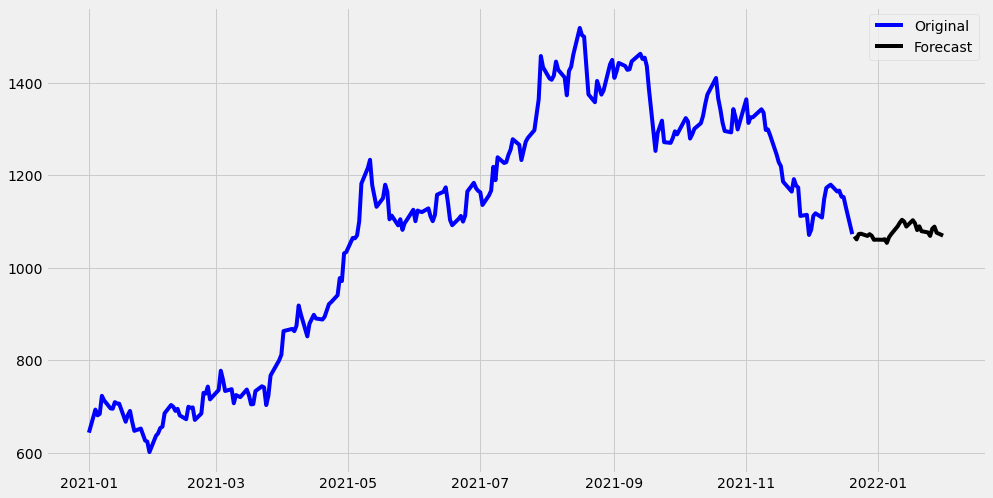

In [35]:
df_forecast1 = df_next1.copy()
df_forecast1.set_index('Date', inplace= True)

plt.plot(df_Close['Close'], color= 'blue', label= 'Original')
plt.plot(df_forecast1['Close'], color= 'black', label= 'Forecast')
plt.legend(loc='best')
plt.show()

# plt.plot(df_forecast1['Close'], color= 'green', label= 'Forecast')
# plt.legend(loc='best')
# plt.show()

In [36]:
df_final2 = pd.concat([df_Close, df_forecast1], axis=0)
df_final2 = df_final2.loc[:,['Close']]
df_final2.tail(31)

,Close
Date,
2021-12-20,1072.949951
2021-12-21,1068.006578
2021-12-22,1061.627918
2021-12-23,1073.076477
2021-12-24,1073.910839
2021-12-27,1069.052735
2021-12-28,1072.904985
2021-12-29,1069.526186
2021-12-30,1060.694303


---

##### ORDER (3,2,3)

In [37]:
model_SARIMAX3 = SARIMAX(df_Close.Close, trend='n', order=(3,2,3), seasonal_order=(3,2,3,12))

model_SARIMAX3_fit = model_SARIMAX3.fit()

print(model_SARIMAX3_fit.summary())  # Summary of Fit Model

/Users/eben.emmanuel/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/eben.emmanuel/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.81448D+00    |proj g|=  1.07750D-01

At iterate    5    f=  4.79203D+00    |proj g|=  8.95098D-03

At iterate   10    f=  4.77340D+00    |proj g|=  7.41523D-02

At iterate   15    f=  4.70996D+00    |proj g|=  2.11437D-01

At iterate   20    f=  4.50913D+00    |proj g|=  5.87296D-01

At iterate   25    f=  4.48686D+00    |proj g|=  4.17696D-01

At iterate   30    f=  4.47933D+00    |proj g|=  1.42347D-01

At iterate   35    f=  4.47551D+00    |proj g|=  7.51946D-02

At iterate   40    f=  4.47241D+00    |proj g|=  1.04083D-01

At iterate   45    f=  4.47196D+00    |proj g|=  2.06769D-02


/Users/eben.emmanuel/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  4.47155D+00    |proj g|=  6.95507D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     64      1     0     0   6.955D-02   4.472D+00
  F =   4.4715484192881503     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                  239
Model:             SARIMAX(3, 2, 3)x(3, 2, 3, 12)   Log Likelihood               -1068.700
Date:                            Mon, 10 Jan 2022   AIC                           2163.4

### Checking SARIMAX (3,2,3) Model

<AxesSubplot:xlabel='Date'>

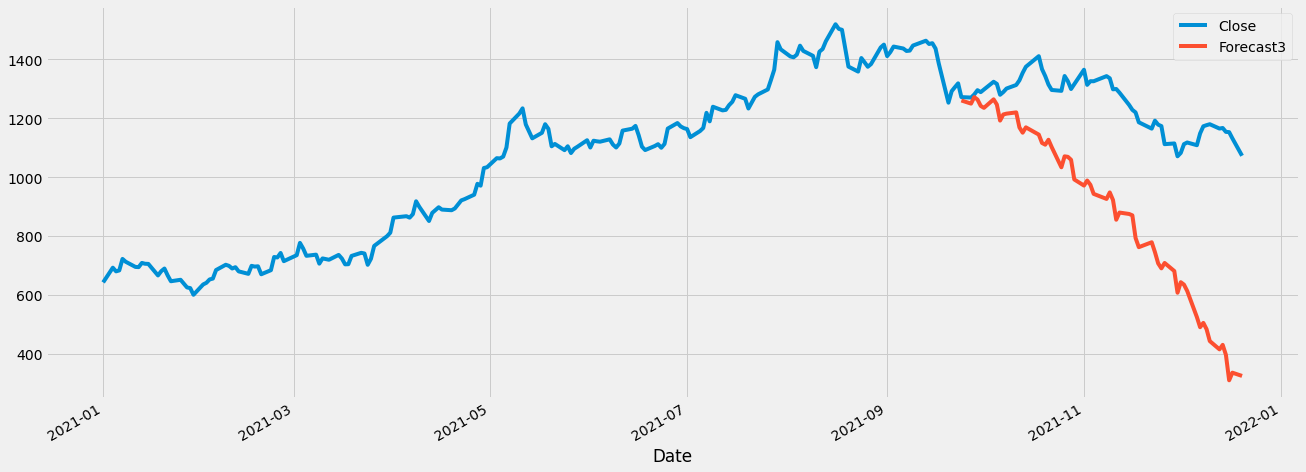

In [38]:
## Checking if our Model is Forcasting well for the existing Data.
df_Close['Forecast3'] = model_SARIMAX3_fit.predict(start= 180, end= 238, dynamic= True)
df_Close[['Close','Forecast3']].plot(figsize= (20,8))

### Forecasting the Stock Closing Price SARIMAX (3,2,3)

In [39]:
Days_Required = 30

df_next2 = pd.DataFrame(model_SARIMAX3_fit.forecast(steps= Days_Required, alpha= 0.05))       ## 95% Confidence Interval
df_next2['Date'] = pd.date_range(start= datetime.date(2021, 12, 21), periods= Days_Required, freq= 'B')      ## Obtaining only the Business Days.

df_next2.rename(columns = {'predicted_mean':'Close'}, inplace = True)

df_next2.tail()

/Users/eben.emmanuel/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


,Close,Date
264,711.688121,2022-01-25
265,719.090960,2022-01-26
266,708.347419,2022-01-27
267,719.751404,2022-01-28
268,707.858894,2022-01-31


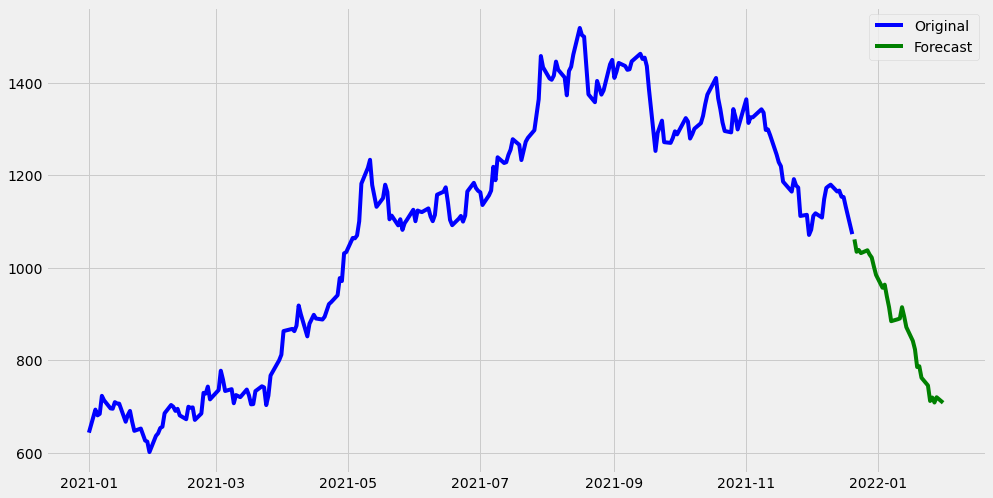

In [40]:
df_forecast2 = df_next2.copy()
df_forecast2.set_index('Date', inplace= True)

plt.plot(df_Close['Close'], color= 'blue', label= 'Original')
plt.plot(df_forecast2['Close'], color= 'green', label= 'Forecast')
plt.legend(loc='best')
plt.show()

# plt.plot(df_forecast2['Close'], color= 'green', label= 'Forecast')
# plt.legend(loc='best')
# plt.show()

In [41]:
df_final3 = pd.concat([df_Close, df_forecast2], axis=0)
df_final3 = df_final3.loc[:,['Close']]
df_final3.tail(31) 

,Close
Date,
2021-12-20,1072.949951
2021-12-21,1061.559159
2021-12-22,1034.786778
2021-12-23,1038.633109
2021-12-24,1031.880796
2021-12-27,1037.971811
2021-12-28,1028.919538
2021-12-29,1022.292579
2021-12-30,1002.704933


---

##### ORDER (4,1,3)

In [42]:
model_SARIMAX4 = SARIMAX(df_Close.Close, trend='n', order=(4,1,3), seasonal_order=(4,1,3,12))

model_SARIMAX4_fit = model_SARIMAX4.fit()

print(model_SARIMAX4_fit.summary())  # Summary of Fit Model

/Users/eben.emmanuel/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/eben.emmanuel/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.64957D+00    |proj g|=  1.52577D-01

At iterate    5    f=  4.60961D+00    |proj g|=  3.30524D-02

At iterate   10    f=  4.59991D+00    |proj g|=  1.27054D-02

At iterate   15    f=  4.58606D+00    |proj g|=  7.25524D-02

At iterate   20    f=  4.57294D+00    |proj g|=  5.56219D-02

At iterate   25    f=  4.56033D+00    |proj g|=  1.20644D-01

At iterate   30    f=  4.54706D+00    |proj g|=  5.93033D-01

At iterate   35    f=  4.54138D+00    |proj g|=  1.72777D-02

At iterate   40    f=  4.54128D+00    |proj g|=  2.43678D-02

At iterate   45    f=  4.54014D+00    |proj g|=  2.86526D-01


/Users/eben.emmanuel/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  4.53556D+00    |proj g|=  3.89456D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   15     50     63      1     0     0   3.895D-01   4.536D+00
  F =   4.5355599359432652     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                  239
Model:             SARIMAX(4, 1, 3)x(4, 1, 3, 12)   Log Likelihood               -1083.999
Date:                            Mon, 10 Jan 2022   AIC                           2197.9

### Checking SARIMAX (4,1,3) Model

<AxesSubplot:xlabel='Date'>

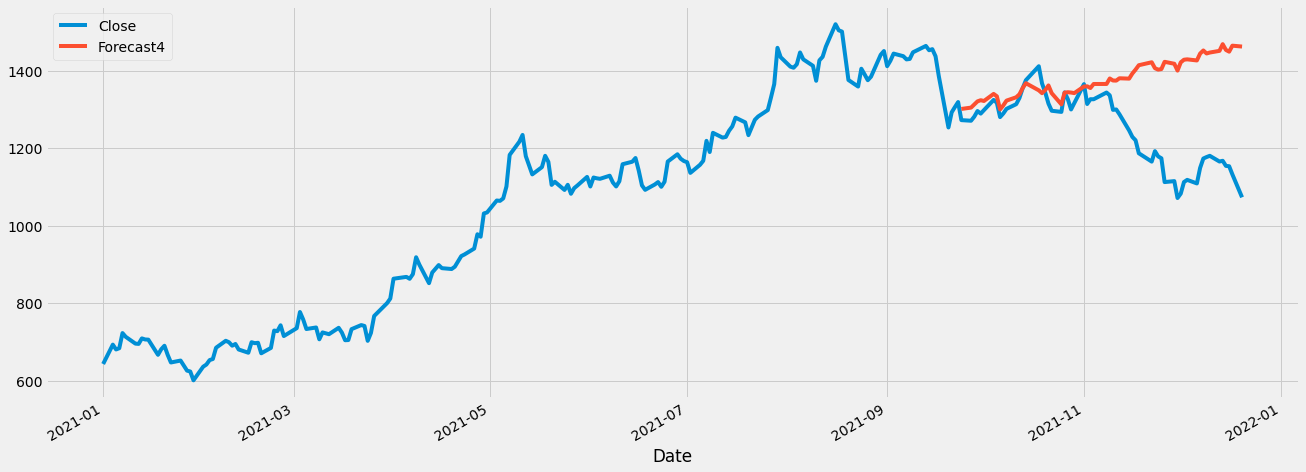

In [43]:
## Checking if our Model is Forcasting well for the existing Data.
df_Close['Forecast4'] = model_SARIMAX4_fit.predict(start= 180, end= 238, dynamic= True)
df_Close[['Close','Forecast4']].plot(figsize= (20,8))

### Forecasting the Stock Closing Price SARIMAX (4,1,3)

In [44]:
Days_Required = 30

df_next3 = pd.DataFrame(model_SARIMAX4_fit.forecast(steps= Days_Required, alpha= 0.05))       ## 95% Confidence Interval
df_next3['Date'] = pd.date_range(start= datetime.date(2021, 12, 21), periods= Days_Required, freq= 'B')      ## Obtaining only the Business Days.

df_next3.rename(columns = {'predicted_mean':'Close'}, inplace = True)

df_next3.tail()

/Users/eben.emmanuel/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


,Close,Date
264,1079.742394,2022-01-25
265,1101.645059,2022-01-26
266,1107.688753,2022-01-27
267,1089.383077,2022-01-28
268,1086.744275,2022-01-31


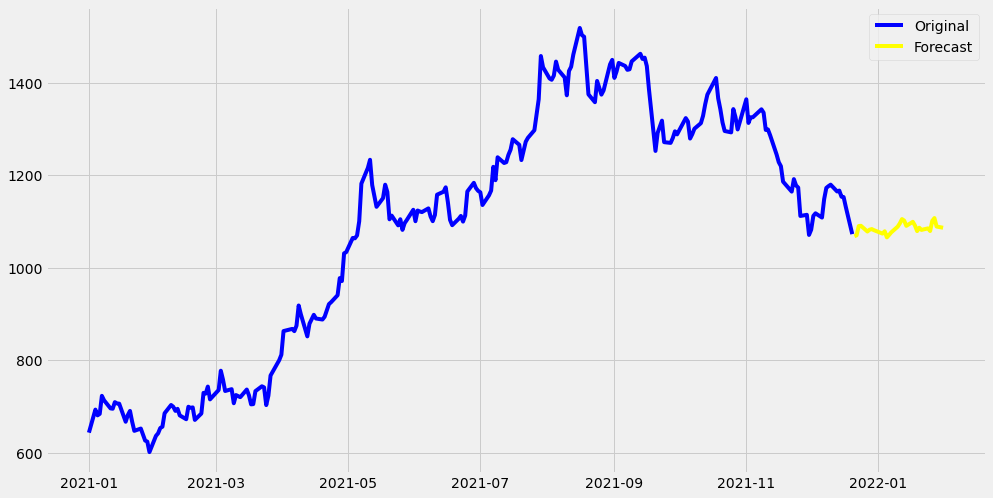

In [45]:
df_forecast3 = df_next3.copy()
df_forecast3.set_index('Date', inplace= True)

plt.plot(df_Close['Close'], color= 'blue', label= 'Original')
plt.plot(df_forecast3['Close'], color= 'yellow', label= 'Forecast')
plt.legend(loc='best')
plt.show()

# plt.plot(df_forecast3['Close'], color= 'green', label= 'Forecast')
# plt.legend(loc='best')
# plt.show()

In [46]:
df_final4 = pd.concat([df_Close, df_forecast3], axis=0)
df_final4 = df_final4.loc[:,['Close']]
df_final4.tail(31) 

,Close
Date,
2021-12-20,1072.949951
2021-12-21,1068.392761
2021-12-22,1070.446651
2021-12-23,1090.415313
2021-12-24,1090.999800
2021-12-27,1078.635234
2021-12-28,1082.502998
2021-12-29,1083.880171
2021-12-30,1081.545877


### Plotting all the Forecasts

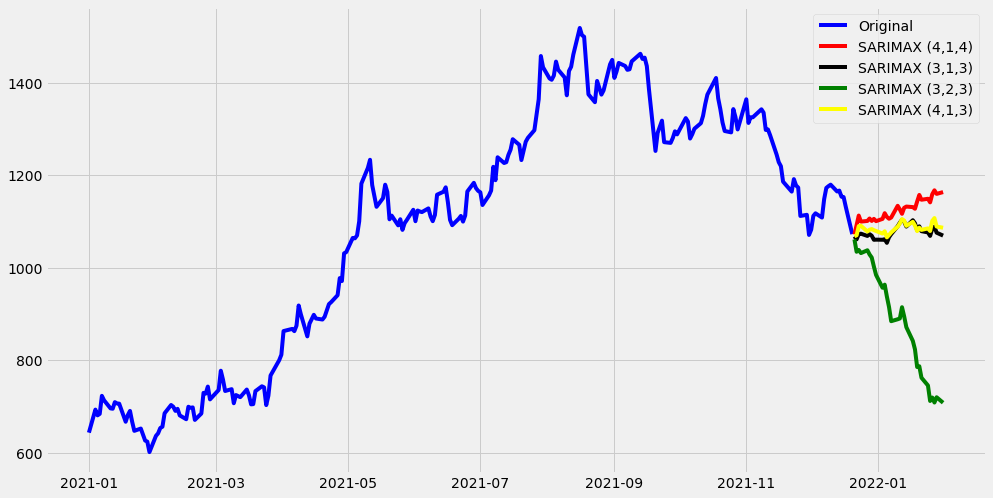

In [47]:
plt.plot(df_Close['Close'], color= 'blue', label= 'Original')
plt.plot(df_forecast['Close'], color= 'red', label= 'SARIMAX (4,1,4)')
plt.plot(df_forecast1['Close'], color= 'black', label= 'SARIMAX (3,1,3)')
plt.plot(df_forecast2['Close'], color= 'green', label= 'SARIMAX (3,2,3)')
plt.plot(df_forecast3['Close'], color= 'yellow', label= 'SARIMAX (4,1,3)')
plt.legend(loc='best')
plt.show()

---
---